In [16]:
from fastai.vision.all import *
import os, pandas as pd
import matplotlib.pyplot as plt
import PIL
import librosa, librosa.display

In [87]:
DATA = Path('../../data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'
AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'

In [85]:
df = pd.read_csv(AUDIO_TAGGING/'train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [86]:
df_test = pd.read_csv(AUDIO_TAGGING/'test_post_competition.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [13]:
AUDIO_RECORDINGS.ls()

(#9473) [Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/2a871432.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/704d6fc7.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/f5729f4f.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/84d0e459.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/0b3c0588.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/56a59a85.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/f8742dce.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/1f4a7bfe.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/151b80e7.wav'),Path('/home/oyvind/Documents/DAT255/data/freesound-audio-tagging/audio_train/c3015f33.wav')...]

In [14]:
file = AUDIO_RECORDINGS/'56a59a85.wav'

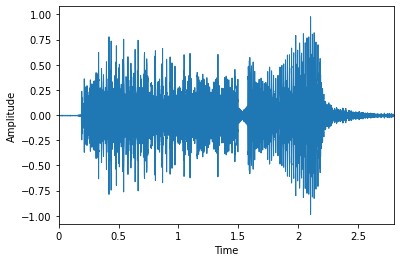

In [17]:
signal, sr = librosa.load(file, sr=22050)
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [18]:
fft = np.fft.fft(signal) # fft -> spectrum 
magnitude = np.abs(fft)

In [19]:
frequency = np.linspace(0, sr, len(magnitude))

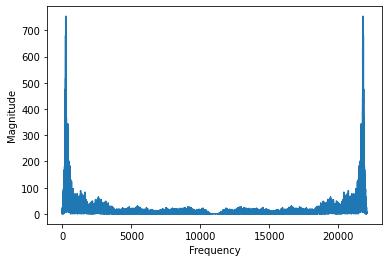

In [21]:
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.plot(frequency, magnitude)
plt.show()

In [22]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)

In [26]:
log_spectogram = librosa.amplitude_to_db(spectogram)

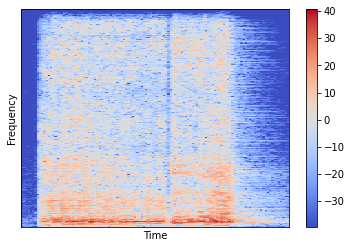

In [27]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [28]:
MFFSc = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

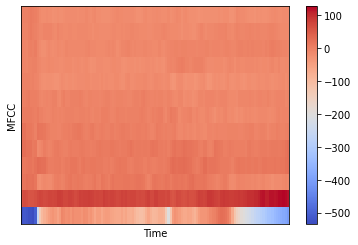

In [29]:
librosa.display.specshow(MFFSc, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [36]:
def log_spec(fname, src_path, dst_path):
    src_path, dst_path = Path(src_path), Path(dst_path)
    
    kind = df.loc[df['fname'].eq(fname), 'label'].iloc[0]
    
    dst_path = dst_path/kind
    
    dst_path.mkdir(exist_ok=True)
    
    x, sample_rate = librosa.load(src_path/fname)
    
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2
    
    stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
    spectogram = np.abs(stft)
    log_spectogram = librosa.amplitude_to_db(spectogram)
    
    dst_fname = dst_path / (fname.split(".wav")[0]+".png")
    plt.imsave(dst_fname, log_spectogram)

In [31]:
src_path = AUDIO_TAGGING/'audio_train/'

In [83]:
dst_path = DATA/'free-sound/train'

In [63]:
def cut_if_necessary(signal, num_samples):
    if signal > num_samples:
        signal = signal[: , : signal]
    return signal

In [64]:
def conv_spectogram(path):
    count = 0
    total = len(path.ls())
    for file in os.listdir(path):
        if (count % 100 == 0):
            print(f'{count}/{total}')
        #print(os.fsdecode(file))
        log_spec(os.fsdecode(file), src_path, dst_path) 
        count += 1

In [65]:
#conv_spectogram(src_path)

In [66]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(),
get_y=parent_label,
item_tfms=RandomResizedCrop(128, min_scale=0.35),
batch_tfms= [*aug_transforms(size=224, max_warp=0)])

In [74]:
dls = dblock.dataloaders(dst_path)

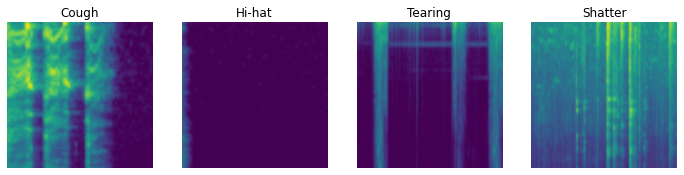

In [75]:
dls.valid.show_batch(max_n=4, nrows=1)

In [76]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

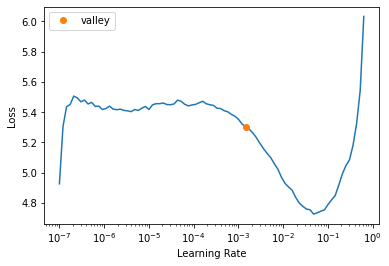

In [77]:
lr = learn.lr_find()

In [78]:
lrate = lr.valley

In [79]:
learn.fine_tune(10, lrate)

epoch,train_loss,valid_loss,error_rate,time
0,3.765927,2.625751,0.682682,00:21


epoch,train_loss,valid_loss,error_rate,time
0,2.770224,2.323290,0.612988,00:27
1,2.366171,2.008204,0.546991,00:28
2,1.976699,1.863112,0.498416,00:29
3,1.728827,1.717880,0.469905,00:28
4,1.469006,1.713844,0.444562,00:29
5,1.273489,1.687476,0.442450,00:27
6,1.081521,1.650979,0.422914,00:28
7,0.970071,1.635615,0.418163,00:28
8,0.914878,1.605299,0.406019,00:27
9,0.838658,1.576399,0.405491,00:27


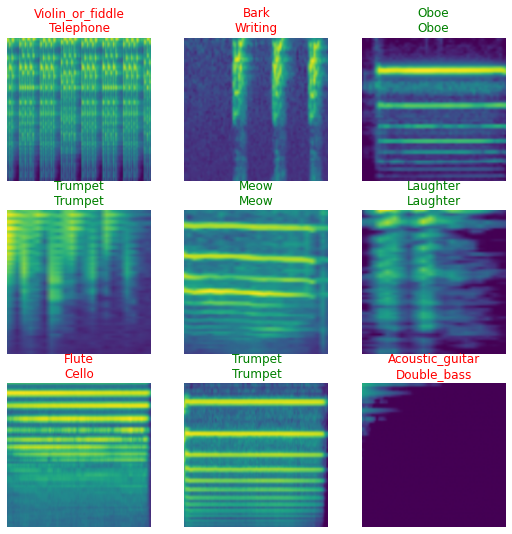

In [80]:
learn.show_results()

In [81]:
a = ClassificationInterpretation.from_learner(learn)

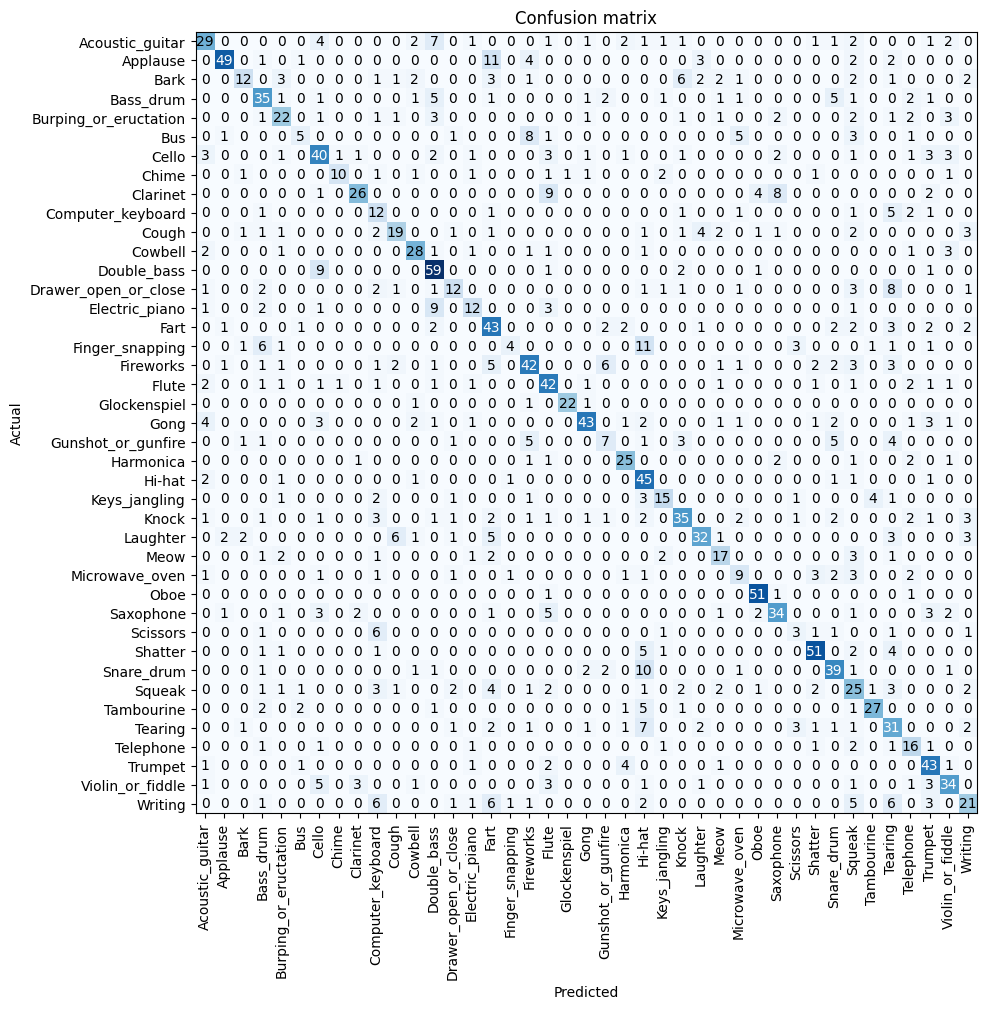

In [82]:
a.plot_confusion_matrix(figsize=(10,10), dpi = 100)